In [1]:
import os, time, glob
from pathlib import Path
from typing import Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

TS_COL = "Timestamp"
_TS_FMT = "%m:%d:%Y %H:%M:%S:%f"


In [2]:

SILVER_DIR  = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\silver")
SCORES_DIR  = SILVER_DIR / "scores"
PATTERN_DIR = SILVER_DIR / "anomalies_pattern"
CONTR_P_DIR = SILVER_DIR / "contribs_point"
METRICS_DIR = SILVER_DIR / "metrics"

for d in [SCORES_DIR, PATTERN_DIR, CONTR_P_DIR, METRICS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def silver_counts():
    print("scores  :", len(list(SCORES_DIR.rglob("*.parquet"))))
    print("patterns:", len(list(PATTERN_DIR.rglob("*.parquet"))))
    print("contribs:", len(list(CONTR_P_DIR.rglob("*.parquet"))))
    print("metrics :", len(list(METRICS_DIR.rglob("*.parquet"))))

silver_counts()


scores  : 116
patterns: 14
contribs: 112
metrics : 0


In [3]:
def _read_parquets(paths: List[Path]) -> pd.DataFrame:
    if not paths: return pd.DataFrame()
    return pd.concat([pd.read_parquet(p) for p in paths], ignore_index=True)

def _parse_ts(df: pd.DataFrame, col: str = TS_COL) -> pd.DataFrame:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format=_TS_FMT, errors="coerce")
    return df

def _latest_batch_id() -> Optional[int]:
    files = list(SCORES_DIR.rglob("*.parquet"))
    if not files: return None
    df = _read_parquets(files)
    if "batch_id" not in df.columns: return None
    return int(pd.to_numeric(df["batch_id"], errors="coerce").max())

def load_scores(limit_rows: Optional[int] = None,
                only_latest_batch: bool = False) -> pd.DataFrame:
    files = list(SCORES_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    if only_latest_batch and "batch_id" in df.columns:
        bid = pd.to_numeric(df["batch_id"], errors="coerce").max()
        df = df[df["batch_id"] == bid]
    df = _parse_ts(df, TS_COL).sort_values(TS_COL)
    if limit_rows: df = df.tail(limit_rows)
    return df.reset_index(drop=True)

def load_patterns() -> pd.DataFrame:
    files = list(PATTERN_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    df = _parse_ts(df, "start_ts")
    df = _parse_ts(df, "end_ts")
    return df.sort_values("start_ts").reset_index(drop=True)

def load_contribs() -> pd.DataFrame:
    files = list(CONTR_P_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    df = _parse_ts(df, TS_COL)
    return df

def load_metrics_latest() -> dict:
    files = list(METRICS_DIR.rglob("*.parquet"))
    if not files: return {}
    df = _read_parquets(files)
    df = df.sort_values("processed_at") if "processed_at" in df.columns else df
    return df.iloc[-1].to_dict()


In [4]:
print("Latest batch_id:", _latest_batch_id())
scores_head = load_scores(limit_rows=5, only_latest_batch=False)
display(scores_head.tail(5))

Latest batch_id: 3


,Timestamp,dense_mse,lstm_mse,is_point,base_score,is_pattern,pattern_id,batch_id,processed_at,pctl_thr,roll_med,roll_mad
0,2025-08-21 13:38:18,2.781740,3.005859,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-21 13:38:19,2.854404,2.983991,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-21 13:38:20,3.182129,2.998839,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,0.100000,0.200000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,0.100000,0.200000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def show_latest_batch_tail(last_n: int = 10, refresh_every_sec: int = 10):
    try:
        while True:
            clear_output(wait=True)
            bid = _latest_batch_id()
            if bid is None:
                print("No scored data yet."); time.sleep(refresh_every_sec); continue
            df = load_scores(only_latest_batch=True)
            if df.empty:
                print("No scored data yet."); time.sleep(refresh_every_sec); continue
            cols = [TS_COL, "dense_mse", "lstm_mse", "is_point", "is_pattern", "pattern_id",
                    "batch_id", "processed_at"]
            cols = [c for c in cols if c in df.columns]
            display(df.tail(last_n)[cols])
            print(f"(Latest batch_id={bid} • updating every {refresh_every_sec}s)")
            time.sleep(refresh_every_sec)
    except KeyboardInterrupt:
        print("Stopped live tail.")


def show_latest_batch_tail_once(last_n: int = 10):
    bid = _latest_batch_id()
    if bid is None:
        print("No scored data yet."); return
    df = load_scores(only_latest_batch=True)
    cols = [TS_COL, "dense_mse", "lstm_mse", "is_point", "is_pattern", "pattern_id",
            "batch_id", "processed_at"]
    cols = [c for c in cols if c in df.columns]
    display(df.tail(last_n)[cols])


show_latest_batch_tail_once(10)


,Timestamp,dense_mse,lstm_mse,is_point,is_pattern,pattern_id,batch_id,processed_at
1990,2025-08-21 13:00:32,3.664060,2.975407,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1991,2025-08-21 13:00:33,2.542423,2.968219,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1992,2025-08-21 13:00:34,2.666021,2.958745,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1993,2025-08-21 13:00:35,3.415523,2.957977,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1994,2025-08-21 13:00:36,3.000982,2.972914,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1995,2025-08-21 13:00:37,3.512613,2.993061,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1996,2025-08-21 13:00:38,3.446550,2.992289,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1997,2025-08-21 13:00:39,3.417509,3.000011,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1998,2025-08-21 13:00:40,4.099998,3.047994,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1999,2025-08-21 13:00:41,3.578324,3.055083,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00


In [8]:
def _base_score_series(df: pd.DataFrame) -> pd.Series:
    lstm = df["lstm_mse"] if "lstm_mse" in df.columns else pd.Series(index=df.index, dtype=float)
    dense = df["dense_mse"] if "dense_mse" in df.columns else pd.Series(index=df.index, dtype=float)
    return np.where(np.isfinite(lstm), lstm, dense)

def _latest_threshold(df: pd.DataFrame) -> float:
    m = load_metrics_latest()
    if "pctl_thr" in m and pd.notnull(m["pctl_thr"]):
        return float(m["pctl_thr"])
    bs = _base_score_series(df)
    if len(bs) == 0: return np.inf
    return float(np.nanpercentile(bs, 99))


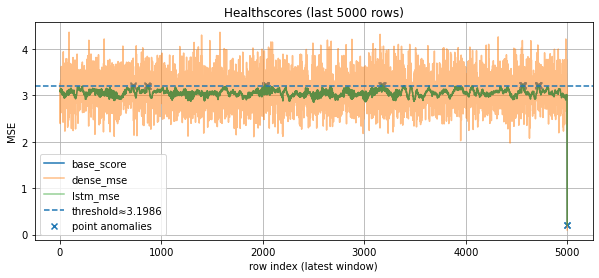

In [9]:
def plot_healthscores(window_rows: int = 5000, title: str = "Healthscores"):
    df = load_scores(limit_rows=window_rows, only_latest_batch=False)
    if df.empty:
        print("No scored data yet."); return
    df["base_score"] = _base_score_series(df)

    thr = _latest_threshold(df)
    x = np.arange(len(df))

    plt.figure()
    plt.plot(x, df["base_score"].values, label="base_score")
    if "dense_mse" in df.columns:
        plt.plot(x, df["dense_mse"].values, label="dense_mse", alpha=0.5)
    if "lstm_mse" in df.columns:
        plt.plot(x, df["lstm_mse"].values, label="lstm_mse", alpha=0.5)
    plt.axhline(thr, linestyle="--", label=f"threshold≈{thr:.4f}")

    if "is_point" in df.columns:
        idx = np.where(df["is_point"].astype(bool).values)[0]
        if len(idx) > 0:
            plt.scatter(idx, df["base_score"].values[idx], marker="x", label="point anomalies")

    plt.title(title + f" (last {len(df)} rows)")
    plt.xlabel("row index (latest window)"); plt.ylabel("MSE")
    plt.legend()
    plt.show()

plot_healthscores(5000)

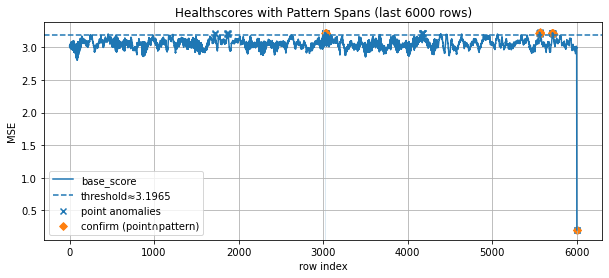

In [10]:
def plot_healthscores_with_patterns(window_rows: int = 5000):
    df = load_scores(limit_rows=window_rows, only_latest_batch=False)
    if df.empty:
        print("No scored data yet."); return
    df["base_score"] = _base_score_series(df)
    thr = _latest_threshold(df)
    x = np.arange(len(df))

    plt.figure()
    plt.plot(x, df["base_score"].values, label="base_score")
    plt.axhline(thr, linestyle="--", label=f"threshold≈{thr:.4f}")

    if {"is_pattern", "pattern_id"}.issubset(df.columns):
        pid = df["pattern_id"].values
        is_pat = df["is_pattern"].astype(bool).values
        i = 0
        while i < len(df):
            if is_pat[i]:
                j = i
                while j+1 < len(df) and is_pat[j+1] and pid[j+1] == pid[i]:
                    j += 1
                plt.axvspan(i, j, alpha=0.15)  
                i = j + 1
            else:
                i += 1

    if "is_point" in df.columns:
        idx_p = np.where(df["is_point"].astype(bool).values)[0]
        if len(idx_p) > 0:
            plt.scatter(idx_p, df["base_score"].values[idx_p], marker="x", label="point anomalies")

    if {"is_point", "is_pattern"}.issubset(df.columns):
        conf = df["is_point"].astype(bool) & df["is_pattern"].astype(bool)
        idx_c = np.where(conf.values)[0]
        if len(idx_c) > 0:
            plt.scatter(idx_c, df["base_score"].values[idx_c], marker="D", s=30, label="confirm (point∩pattern)")

    plt.title(f"Healthscores with Pattern Spans (last {len(df)} rows)")
    plt.xlabel("row index"); plt.ylabel("MSE")
    plt.legend()
    plt.show()

plot_healthscores_with_patterns(6000)


In [11]:
def topk_point_anomalies(k: int = 10) -> pd.DataFrame:
    df = load_scores(limit_rows=None, only_latest_batch=False)
    if df.empty or "is_point" not in df.columns:
        return pd.DataFrame()
    df["base_score"] = _base_score_series(df)
    pts = df[df["is_point"].astype(bool)].copy()
    pts = pts.sort_values("base_score", ascending=False).head(k)
    keep = [TS_COL, "base_score", "dense_mse", "lstm_mse", "is_pattern", "pattern_id", "batch_id", "processed_at"]
    keep = [c for c in keep if c in pts.columns]
    return pts[keep].reset_index(drop=True)

def topk_pattern_anomalies(k: int = 10) -> pd.DataFrame:
    pat = load_patterns()
    if pat.empty:
        return pd.DataFrame()
    score_cols = [c for c in ["max_base_score", "mean_base_score", "length"] if c in pat.columns]
    if "max_base_score" in score_cols:
        pat_top = pat.sort_values(["max_base_score", "length"], ascending=[False, False]).head(k)
    else:
        pat_top = pat.sort_values("length", ascending=False).head(k)
    return pat_top.reset_index(drop=True)

display(topk_point_anomalies(10))
display(topk_pattern_anomalies(10))

,Timestamp,base_score,dense_mse,lstm_mse,is_pattern,pattern_id,batch_id,processed_at
0,2025-08-20 22:26:15,4.159948,4.159948,NaN,NaN,NaN,NaN,NaN
1,2025-08-20 22:26:33,3.646133,3.646133,NaN,NaN,NaN,NaN,NaN
2,2025-08-20 22:26:36,3.627645,3.627645,NaN,NaN,NaN,NaN,NaN
3,2025-08-20 22:26:16,3.574626,3.574626,NaN,NaN,NaN,NaN,NaN
4,2025-08-20 22:26:20,3.491332,3.491332,NaN,NaN,NaN,NaN,NaN
5,2025-08-20 22:26:31,3.423111,3.423111,NaN,NaN,NaN,NaN,NaN
6,2025-08-20 22:26:09,3.419050,3.419050,NaN,NaN,NaN,NaN,NaN
7,2025-08-20 22:26:37,3.410758,3.410758,NaN,NaN,NaN,NaN,NaN
8,2025-08-20 22:26:21,3.407423,3.407423,NaN,NaN,NaN,NaN,NaN
9,2025-08-21 11:42:08,3.329480,3.574872,3.32948,NaN,NaN,NaN,NaN


,pattern_id,start_ts,end_ts,length,max_base_score,mean_base_score
0,1755770065098,2025-08-21 10:56:47,2025-08-21 10:56:57,11,3.317979,3.267868
1,1755770089445,2025-08-21 11:22:34,2025-08-21 11:22:38,5,3.234924,3.224442
2,1755770113606,2025-08-21 12:43:05,2025-08-21 12:43:09,5,3.225644,3.217184
3,1755729918304,2025-08-21 05:04:29,2025-08-21 05:04:35,7,NaN,NaN
4,1755730130461,2025-08-21 10:54:05,2025-08-21 10:54:11,7,NaN,NaN
5,1755730161504,2025-08-21 11:41:59,2025-08-21 11:42:04,6,NaN,NaN
6,1755730099279,2025-08-21 09:03:05,2025-08-21 09:03:09,5,NaN,NaN


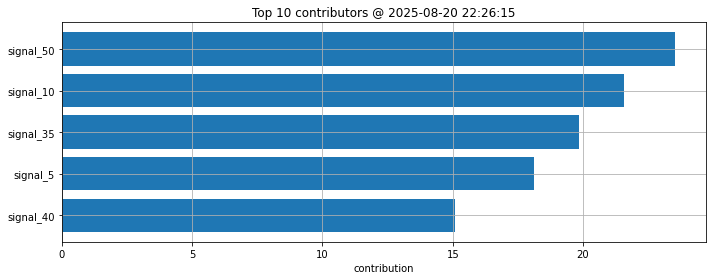

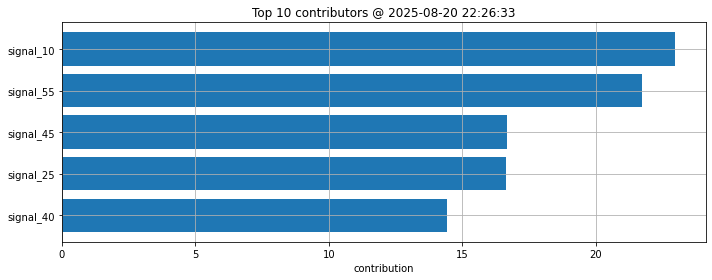

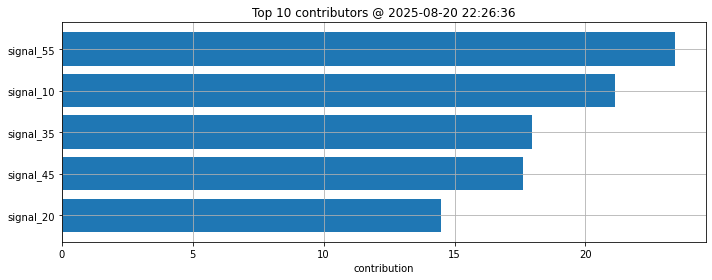

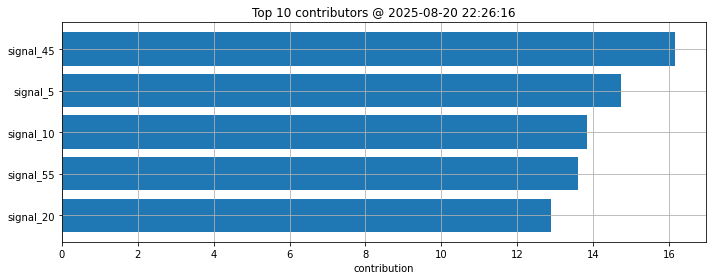

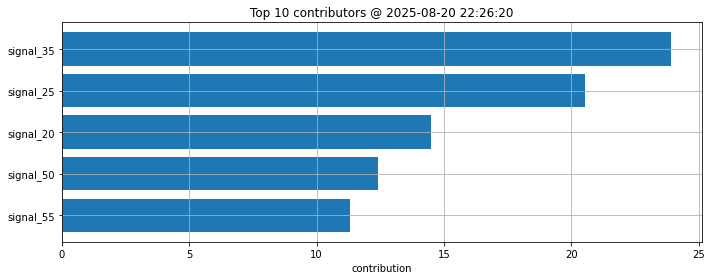

In [12]:
def plot_topk_anomaly_contributors(k_points: int = 5, topn_feats: int = 10):
    pts = topk_point_anomalies(k_points)
    if pts.empty:
        print("No point anomalies yet."); return
    contribs = load_contribs()
    if contribs.empty:
        print("No contributions yet."); return

    for i, row in pts.iterrows():
        ts = row[TS_COL]
        sub = contribs[contribs[TS_COL] == ts]
        if sub.empty: 
            print(f"No contribs for {ts}"); 
            continue
        agg = (sub.groupby("feature")["contribution"].sum()
                  .sort_values(ascending=False)
                  .head(topn_feats))
        plt.figure()
        plt.barh(agg.index.tolist()[::-1], agg.values[::-1])
        plt.title(f"Top {topn_feats} contributors @ {ts}")
        plt.xlabel("contribution")
        plt.tight_layout()
        plt.show()

plot_topk_anomaly_contributors(k_points=5, topn_feats=10)

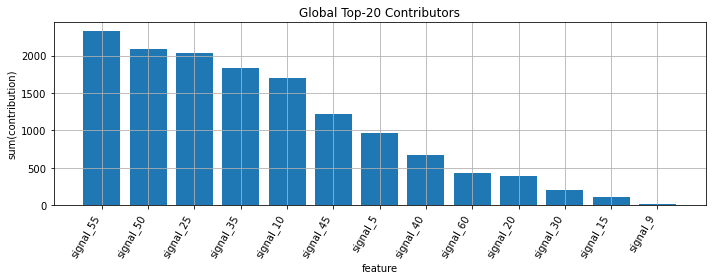

In [14]:
def plot_global_contributors(topn: int = 20):
    df = load_contribs()
    if df.empty:
        print("No contributions yet."); return
    agg = (df.groupby("feature")["contribution"].sum()
             .sort_values(ascending=False)
             .head(topn))
    plt.figure()
    plt.bar(agg.index.tolist(), agg.values)
    plt.xticks(rotation=60, ha="right")
    plt.title(f"Global Top-{topn} Contributors")
    plt.xlabel("feature"); plt.ylabel("sum(contribution)")
    plt.tight_layout()
    plt.show()

plot_global_contributors(20)

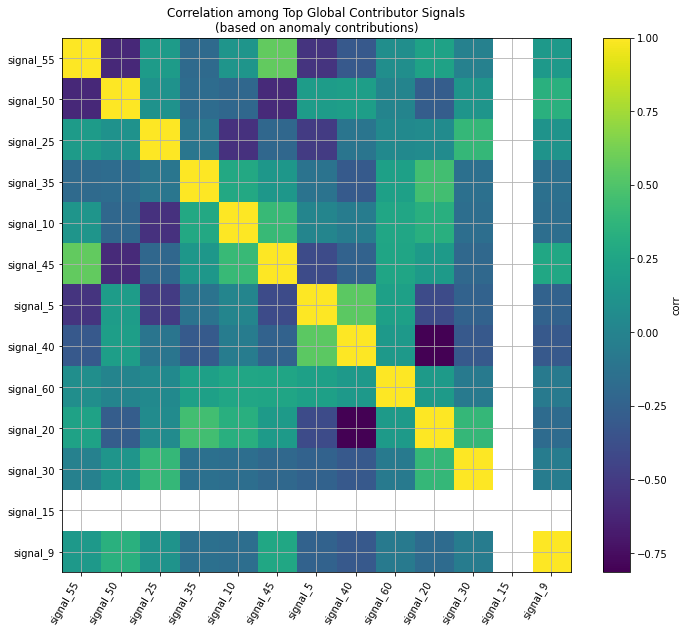

In [15]:
def plot_contrib_correlation(top_k_points: int = 20, top_global_feats: int = 15):
    pts = topk_point_anomalies(top_k_points)
    dfc = load_contribs()
    if pts.empty or dfc.empty:
        print("Need both anomalies and contributions."); return

    # pick top global features
    top_feats = (dfc.groupby("feature")["contribution"].sum()
                   .sort_values(ascending=False)
                   .head(top_global_feats)
                   .index.tolist())

    # build matrix: rows = anomaly timestamps, cols = features, values = contribution
    ts_list = pts[TS_COL].tolist()
    mat = pd.DataFrame(0.0, index=ts_list, columns=top_feats)
    for ts in ts_list:
        sub = dfc[dfc[TS_COL] == ts]
        if sub.empty: continue
        g = sub.groupby("feature")["contribution"].sum()
        for f in top_feats:
            if f in g.index:
                mat.at[ts, f] = float(g.loc[f])

    if mat.shape[0] < 2 or mat.shape[1] < 2:
        print("Not enough data for correlation."); return

    corr = mat.corr()  # feature-feature correlation across anomalies
    plt.figure(figsize=(6 + 0.3*len(top_feats), 5 + 0.3*len(top_feats)))
    plt.imshow(corr.values, aspect="auto", interpolation="nearest")
    plt.xticks(range(len(top_feats)), top_feats, rotation=60, ha="right")
    plt.yticks(range(len(top_feats)), top_feats)
    plt.colorbar(label="corr")
    plt.title("Correlation among Top Global Contributor Signals\n(based on anomaly contributions)")
    plt.tight_layout()
    plt.show()

plot_contrib_correlation(top_k_points=20, top_global_feats=15)

In [17]:
def quick_dashboard(
    window_rows: int = 6000,
    topk_points: int = 10,
    topn_feats_per_anom: int = 10,
    topn_global_feats: int = 20,
    corr_topk_points: int = 20,
    corr_top_global_feats: int = 15,
    refresh_every_sec: int = None  
):
    import time
    from IPython.display import clear_output, display

    def _run_once():
        clear_output(wait=True)

    
        print("=== Latest Batch Tail (last 10 rows) ===")
        try:
            show_latest_batch_tail_once(10)
        except Exception as e:
            print("Latest batch tail unavailable:", e)

       
        print("\n=== Healthscores + Threshold + Point & Pattern Overlays ===")
        try:
            plot_healthscores_with_patterns(window_rows)
        except Exception as e:
            print("Healthscore plot unavailable:", e)

        
        print("\n=== Top-K Point Anomalies ===")
        try:
            pts = topk_point_anomalies(topk_points)
            if pts is None or len(pts) == 0:
                print("No point anomalies yet.")
            else:
                display(pts)
        except Exception as e:
            print("Top-K point anomalies unavailable:", e)

        
        print("\n=== Top-K Pattern Anomalies ===")
        try:
            pats = topk_pattern_anomalies(topk_points)
            if pats is None or len(pats) == 0:
                print("No pattern anomalies yet.")
            else:
                display(pats)
        except Exception as e:
            print("Top-K pattern anomalies unavailable:", e)

       
        print(f"\n=== Per-Anomaly Top {topn_feats_per_anom} Contributors "
              f"(for top {min(topk_points,5)} point anomalies) ===")
        try:

            plot_topk_anomaly_contributors(
                k_points=min(topk_points, 5),
                topn_feats=topn_feats_per_anom
            )
        except Exception as e:
            print("Per-anomaly contributor charts unavailable:", e)

        
        print("\n=== Global Top Contributors ===")
        try:
            plot_global_contributors(topn_global_feats)
        except Exception as e:
            print("Global contributors plot unavailable:", e)

        
        print("\n=== Contribution Correlation Heatmap "
              f"(top_k_points={corr_topk_points}, top_global_feats={corr_top_global_feats}) ===")
        try:
            plot_contrib_correlation(
                top_k_points=corr_topk_points,
                top_global_feats=corr_top_global_feats
            )
        except Exception as e:
            print("Correlation heatmap unavailable:", e)

    if refresh_every_sec is None:
        _run_once()
    else:
        try:
            while True:
                _run_once()
                print(f"\n(Refreshing every {refresh_every_sec}s — press Stop/Interrupt to end)")
                time.sleep(refresh_every_sec)
        except KeyboardInterrupt:
            print("Stopped dashboard refresh.")
    


In [ ]:
quick_dashboard()

=== Latest Batch Tail (last 10 rows) ===


,Timestamp,dense_mse,lstm_mse,is_point,is_pattern,pattern_id,batch_id,processed_at
1990,2025-08-21 13:00:32,3.664060,2.975407,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1991,2025-08-21 13:00:33,2.542423,2.968219,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1992,2025-08-21 13:00:34,2.666021,2.958745,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1993,2025-08-21 13:00:35,3.415523,2.957977,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1994,2025-08-21 13:00:36,3.000982,2.972914,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1995,2025-08-21 13:00:37,3.512613,2.993061,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1996,2025-08-21 13:00:38,3.446550,2.992289,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1997,2025-08-21 13:00:39,3.417509,3.000011,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1998,2025-08-21 13:00:40,4.099998,3.047994,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1999,2025-08-21 13:00:41,3.578324,3.055083,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00



=== Healthscores + Threshold + Point & Pattern Overlays ===


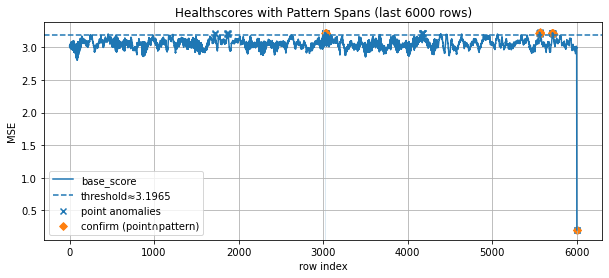


=== Top-K Point Anomalies ===


,Timestamp,base_score,dense_mse,lstm_mse,is_pattern,pattern_id,batch_id,processed_at
0,2025-08-20 22:26:15,4.159948,4.159948,NaN,NaN,NaN,NaN,NaN
1,2025-08-20 22:26:33,3.646133,3.646133,NaN,NaN,NaN,NaN,NaN
2,2025-08-20 22:26:36,3.627645,3.627645,NaN,NaN,NaN,NaN,NaN
3,2025-08-20 22:26:16,3.574626,3.574626,NaN,NaN,NaN,NaN,NaN
4,2025-08-20 22:26:20,3.491332,3.491332,NaN,NaN,NaN,NaN,NaN
5,2025-08-20 22:26:31,3.423111,3.423111,NaN,NaN,NaN,NaN,NaN
6,2025-08-20 22:26:09,3.419050,3.419050,NaN,NaN,NaN,NaN,NaN
7,2025-08-20 22:26:37,3.410758,3.410758,NaN,NaN,NaN,NaN,NaN
8,2025-08-20 22:26:21,3.407423,3.407423,NaN,NaN,NaN,NaN,NaN
9,2025-08-21 11:42:08,3.329480,3.574872,3.32948,NaN,NaN,NaN,NaN



=== Top-K Pattern Anomalies ===


,pattern_id,start_ts,end_ts,length,max_base_score,mean_base_score
0,1755770065098,2025-08-21 10:56:47,2025-08-21 10:56:57,11,3.317979,3.267868
1,1755770089445,2025-08-21 11:22:34,2025-08-21 11:22:38,5,3.234924,3.224442
2,1755770113606,2025-08-21 12:43:05,2025-08-21 12:43:09,5,3.225644,3.217184
3,1755729918304,2025-08-21 05:04:29,2025-08-21 05:04:35,7,NaN,NaN
4,1755730130461,2025-08-21 10:54:05,2025-08-21 10:54:11,7,NaN,NaN
5,1755730161504,2025-08-21 11:41:59,2025-08-21 11:42:04,6,NaN,NaN
6,1755730099279,2025-08-21 09:03:05,2025-08-21 09:03:09,5,NaN,NaN



=== Per-Anomaly Top 10 Contributors (for top 5 point anomalies) ===


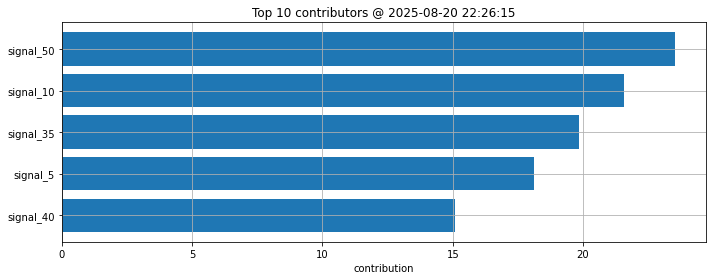

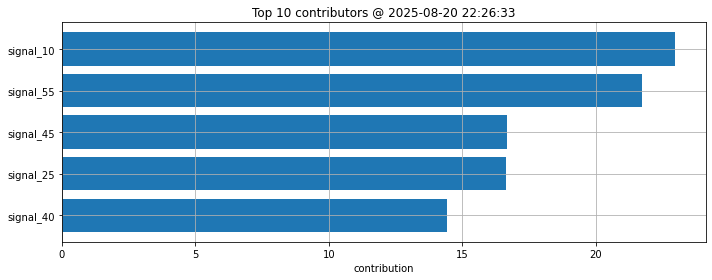

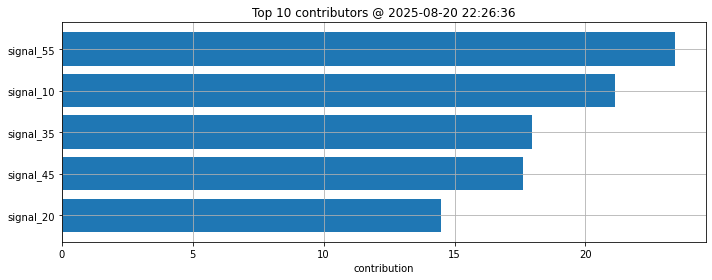

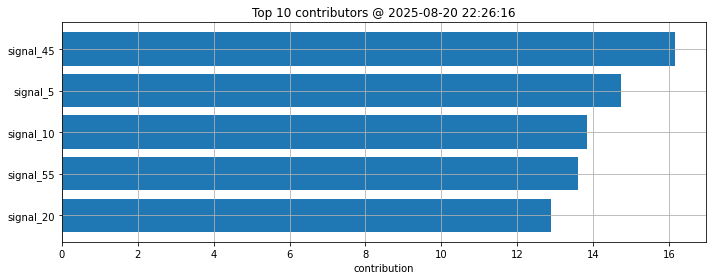

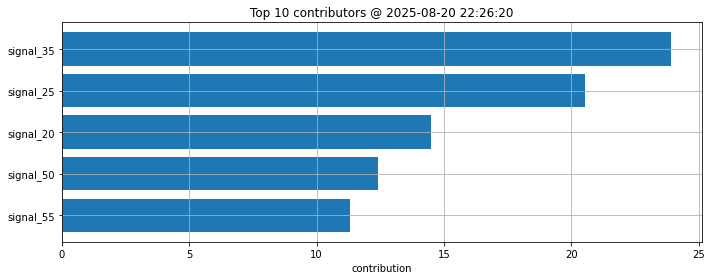


=== Global Top Contributors ===


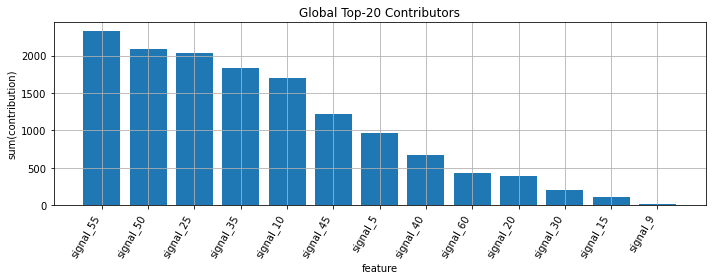


=== Contribution Correlation Heatmap (top_k_points=20, top_global_feats=15) ===


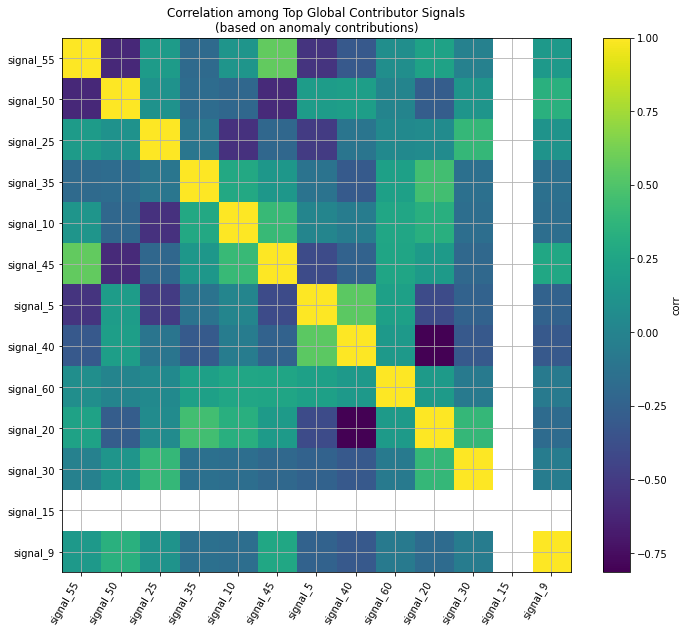


(Refreshing every 60s — press Stop/Interrupt to end)


In [ ]:
quick_dashboard(refresh_every_sec=60)

In [ ]:
quick_dashboard(window_rows=8000, topk_points=15, topn_feats_per_anom=12,
                topn_global_feats=25, corr_topk_points=30, corr_top_global_feats=12)